# RL and Advanced DL: Домашнее задание 1

In [15]:
import gym
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import tqdm
import time
from gym.envs.toy_text.blackjack import BlackjackEnv, cmp, usable_ace, sum_hand, is_bust, score, is_natural
plt.rcParams['figure.figsize'] = [12, 8]

### Часть первая, с блекджеком и стратегиями

In [17]:
env = gym.make('Blackjack-v0', natural=True)

In [19]:
# выйгрыш простой стратегии
num_experiments = 100000
total_reward = []

for _ in range(num_experiments):
    observation = env.reset()
    done = False
    while (observation[0] < 19) and not done:
        observation, reward, done, info = env.step(1)
    if not done:
        observation, reward, done, info = env.step(0)
    total_reward.append(reward)
print(sum(total_reward) / len(total_reward))

-0.181085


In [20]:
# испульзуем е-мягкую стратегию (MC)
def get_action(obs, eps):
    if random.random() < eps:
        return random.randint(0, 1)
    # достаем из словаря для каждого возможного действия сумму очков и количество игр
    list_0 = G[(obs[0], obs[1], obs[2], 0)] if (obs[0], obs[1], obs[2], 0) in G else [0, 1]
    list_1 = G[(obs[0], obs[1], obs[2], 1)] if (obs[0], obs[1], obs[2], 1) in G else [0, 1]
    if (list_0[0] / list_0[1]) > (list_1[0] / list_1[1]):
        return 0
    return 1

In [21]:
def episod(eps):
    observations = []
    observation = env.reset()
    done = False
    # определяем следующее действие по имеющемуся опыту
    action = get_action(observation, eps)
    # сохраняем состояние и действие в массив
    observation = observation[0], observation[1], observation[2], action
    observations.append(observation)
    while (action == 1) and not done:
        observation, reward, done, info = env.step(1)
        # если игра не закончилась, определяем следующее действие
        if done:
            break
        action = get_action(observation, eps)
        observation = observation[0], observation[1], observation[2], action
        observations.append(observation)
    # если игрок перестал брать карты, но игра не закончилась
    if not done:
        observation, reward, done, info = env.step(0)
    # сохраняем опыт по всем промежуточным состояниям
    for obs in observations:
        if obs not in G:
            G[obs] = [0, 0]
        G[obs][0] += reward
        G[obs][1] += 1
    return(reward)

In [22]:
num_experiments = 10000000
window = 100000
total_reward = dict()
reward_cum = dict()
reward_window = dict()
eps_list = [0.01, 0.02, 0.04]

for eps in eps_list:
    G = dict()
    total_reward[eps] = []
    reward_cum[eps] = []
    reward_window[eps] = []
    for _ in tqdm.tqdm(range(num_experiments)):
        total_reward[eps].append(episod(eps))
    # это для графиков
    for i in range(1, num_experiments // window):
        cum_result = sum(total_reward[eps][:i * window]) / (i * window)
        reward_cum[eps].append(cum_result)
        cum_result = sum(total_reward[eps][(i - 1) * window : i * window]) / window
        reward_window[eps].append(cum_result)
    total_gain = sum(total_reward[eps]) / len(total_reward[eps])
    print('Total gain for eps {}: {}'.format(eps, total_gain))
    time.sleep(1)

100%|██████████| 10000000/10000000 [10:12<00:00, 16337.19it/s]


Total gain for eps 0.01: -0.0368858


100%|██████████| 10000000/10000000 [10:22<00:00, 16057.37it/s]


Total gain for eps 0.02: -0.03660885


100%|██████████| 10000000/10000000 [10:18<00:00, 16161.01it/s]


Total gain for eps 0.04: -0.0427418


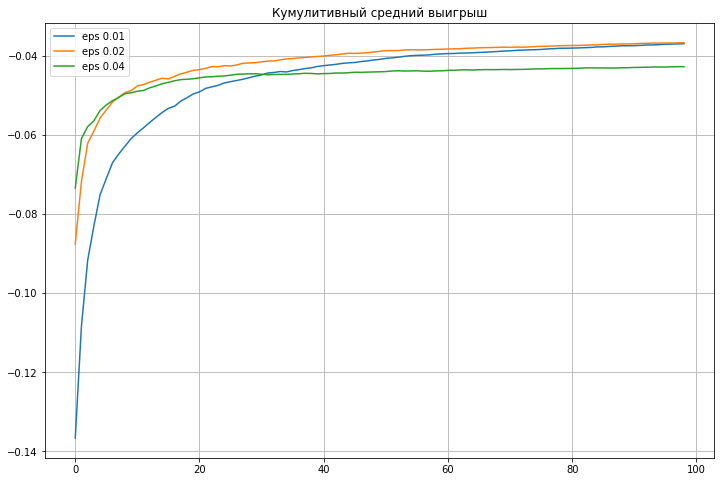

In [23]:
for eps in eps_list:
    plt.plot(reward_cum[eps], label='eps ' + str(eps))
plt.grid()
plt.legend()
plt.title('Кумулитивный средний выигрыш')
plt.show()

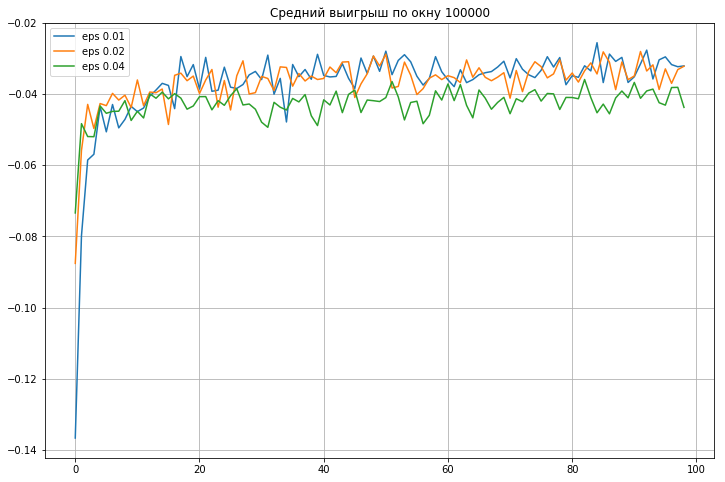

In [24]:
for eps in eps_list:
    plt.plot(reward_window[eps], label='eps ' + str(eps))
plt.grid()
plt.legend()
plt.title('Средний выигрыш по окну ' + str(window))
plt.show()

### Часть вторая, удвоенная

In [25]:
# испульзуем е-мягкую стратегию (MC)
# добавляем возможность удвоить ставку
def get_action_double(obs, eps):
    if random.random() < eps:
        return random.randint(0, 2)
    list_0 = G[(obs[0], obs[1], obs[2], 0)] if (obs[0], obs[1], obs[2], 0) in G else [0, 1]
    list_1 = G[(obs[0], obs[1], obs[2], 1)] if (obs[0], obs[1], obs[2], 1) in G else [0, 1]
    list_2 = G[(obs[0], obs[1], obs[2], 2)] if (obs[0], obs[1], obs[2], 2) in G else [0, 1]
    gain = np.array([
        list_0[0] / list_0[1],
        list_1[0] / list_1[1],
        list_2[0] / list_2[1]
    ])
    return np.argmax(gain)

In [26]:
def episod_double(eps):
    observations = []
    observation = env.reset()
    done = False
    action = get_action_double(observation, eps)
    observation = observation[0], observation[1], observation[2], action
    observations.append(observation)
    while (action != 0) and not done:
        observation, reward, done, info = env.step(1)
        # если игрок удвоил ставку, то это его последняя карта
        if done or (action == 2):
            break
        action = get_action_double(observation, eps)
        observation = observation[0], observation[1], observation[2], action
        observations.append(observation)
    if not done:
        observation, reward, done, info = env.step(0)
    if action == 2:
        reward *= 2
    for obs in observations:
        if obs not in G:
            G[obs] = [0, 0]
        G[obs][0] += reward
        G[obs][1] += 1
    return(reward)

In [28]:
num_experiments = 10000000
window = 100000
total_reward = dict()
reward_cum = dict()
reward_window = dict()
eps_list = [0.01, 0.02, 0.04]

for eps in eps_list:
    G = dict()
    total_reward[eps] = []
    reward_cum[eps] = []
    reward_window[eps] = []
    for _ in tqdm.tqdm(range(num_experiments)):
        total_reward[eps].append(episod_double(eps))
    for i in range(1, num_experiments // window):
        cum_result = sum(total_reward[eps][:i * window]) / (i * window)
        reward_cum[eps].append(cum_result)
        cum_result = sum(total_reward[eps][(i - 1) * window : i * window]) / window
        reward_window[eps].append(cum_result)
    total_gain = sum(total_reward[eps]) / len(total_reward[eps])
    print('Total gain for eps {}: {}'.format(eps, total_gain))
    time.sleep(1)

100%|██████████| 10000000/10000000 [14:13<00:00, 11719.07it/s]


Total gain for eps 0.01: -0.0288537


100%|██████████| 10000000/10000000 [13:46<00:00, 12101.24it/s]


Total gain for eps 0.02: -0.02970305


100%|██████████| 10000000/10000000 [13:34<00:00, 12271.34it/s]


Total gain for eps 0.04: -0.0387088


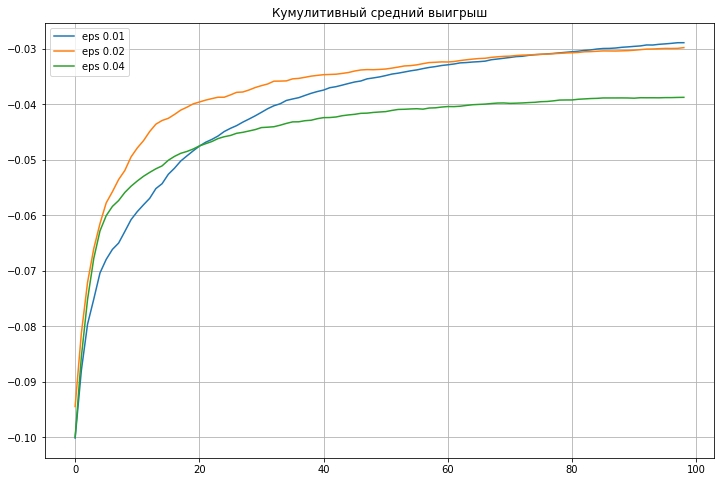

In [29]:
for eps in eps_list:
    plt.plot(reward_cum[eps], label='eps ' + str(eps))
plt.grid()
plt.legend()
plt.title('Кумулитивный средний выигрыш')
plt.show()

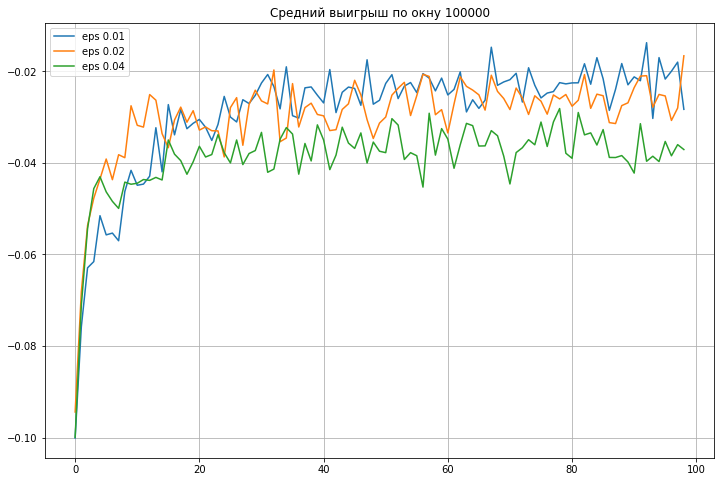

In [30]:
for eps in eps_list:
    plt.plot(reward_window[eps], label='eps ' + str(eps))
plt.grid()
plt.legend()
plt.title('Средний выигрыш по окну ' + str(window))
plt.show()

### Часть третья, в главной роли — Дастин Хоффман

In [31]:
# определим класс, наследуясь от библиотечного, чтобы заменить функцию draw_hand на свою
class MyBlackjackEnv(BlackjackEnv):
    
    def __init__(self, natural=False):
        super().__init__(natural)
    
    def step(self, action):
        assert self.action_space.contains(action)
        if action:  # hit: add a card to players hand and return
            self.player.append(draw_card())
            if is_bust(self.player):
                done = True
                reward = -1.0
            else:
                done = False
                reward = 0.0
        else:  # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card())
            reward = cmp(score(self.player), score(self.dealer))
            if (
                self.natural
                and is_natural(self.player)
                and reward == 1.0
            ):
                # Natural gives extra points, but doesn't autowin. Legacy implementation
                reward = 1.5
        return self._get_obs(), reward, done, {}
    
    def reset(self):
        self.dealer = [draw_card(), draw_card()]
        self.player = draw_hand()
        return self._get_obs()

In [32]:
counter_dict = {
    1: -2,
    2: 1,
    3: 2,
    4: 2,
    5: 3,
    6: 2,
    7: 1,
    8: 0,
    9: -1,
    10: -2
}

In [33]:
def draw_card():
    # оставшиеся в колоде карты
    global deck
    # счетчик карт согласно counter_dict
    global counter
    card = np.random.choice(deck)
    counter += counter_dict[card]
    # удаляем вынутую карты из списка оставшихся
    deck.remove(card)
    # если осталось меньше 15 - мешаем колоду целиком
    if len(deck) < 15:
        deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10] * 4
        counter = 0
    return card

def draw_hand():
    return [draw_card(), draw_card()]

In [34]:
# теперь состояние состоит из 4 элементов: наша сумма, карта дилера, можно ли считать туз как 11 и значение счетчика
# возможных действий попрежнему 3
def get_action_count(obs, eps):
    if random.random() < eps:
        return random.randint(0, 2)
    list_0 = G[(obs[0], obs[1], obs[2], counter, 0)] if (obs[0], obs[1], obs[2], counter, 0) in G else [0, 1]
    list_1 = G[(obs[0], obs[1], obs[2], counter, 1)] if (obs[0], obs[1], obs[2], counter, 1) in G else [0, 1]
    list_2 = G[(obs[0], obs[1], obs[2], counter, 2)] if (obs[0], obs[1], obs[2], counter, 2) in G else [0, 1]
    gain = np.array([
        list_0[0] / list_0[1],
        list_1[0] / list_1[1],
        list_2[0] / list_2[1]
    ])
    return np.argmax(gain)

In [37]:
def episod_count(eps):
    observations = []
    observation = env.reset()
    done = False
    action = get_action_count(observation, eps)
    observation = observation[0], observation[1], observation[2], counter, action
    observations.append(observation)
    while (action != 0) and not done:
        observation, reward, done, info = env.step(1)
        if done or (action == 2):
            break
        action = get_action_count(observation, eps)
        observation = observation[0], observation[1], observation[2], counter, action
        observations.append(observation)
    if not done:
        observation, reward, done, info = env.step(0)
    if action == 2:
        reward *= 2
    for obs in observations:
        if obs not in G:
            G[obs] = [0, 0]
        G[obs][0] += reward
        G[obs][1] += 1
    return(reward)

In [38]:
deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10] * 4
counter = 0
env = MyBlackjackEnv()
num_experiments = 10000000
window = 100000

total_reward = dict()
reward_cum = dict()
reward_window = dict()
eps_list = [0.01, 0.02, 0.04]

for eps in eps_list:
    G = dict()
    total_reward[eps] = []
    reward_cum[eps] = []
    reward_window[eps] = []
    for _ in tqdm.tqdm(range(num_experiments)):
        total_reward[eps].append(episod_count(eps))
    for i in range(1, num_experiments // window):
        cum_result = sum(total_reward[eps][:i * window]) / (i * window)
        reward_cum[eps].append(cum_result)
        cum_result = sum(total_reward[eps][(i - 1) * window : i * window]) / window
        reward_window[eps].append(cum_result)
    total_gain = sum(total_reward[eps]) / len(total_reward[eps])
    print('Total gain for eps {}: {}'.format(eps, total_gain))
    time.sleep(1)

100%|██████████| 10000000/10000000 [19:49<00:00, 8403.86it/s]


Total gain for eps 0.01: -0.0860485


100%|██████████| 10000000/10000000 [20:11<00:00, 8251.77it/s]


Total gain for eps 0.02: -0.0735449


100%|██████████| 10000000/10000000 [20:22<00:00, 8181.64it/s]


Total gain for eps 0.04: -0.074869


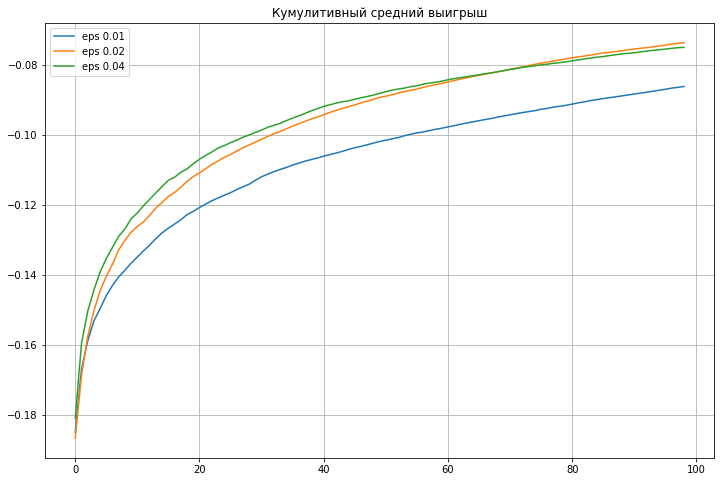

In [39]:
for eps in eps_list:
    plt.plot(reward_cum[eps], label='eps ' + str(eps))
plt.grid()
plt.legend()
plt.title('Кумулитивный средний выигрыш')
plt.show()

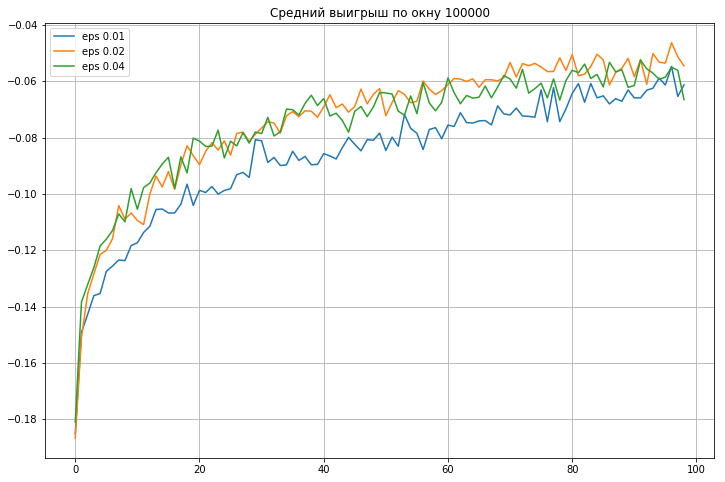

In [40]:
for eps in eps_list:
    plt.plot(reward_window[eps], label='eps ' + str(eps))
plt.grid()
plt.legend()
plt.title('Средний выигрыш по окну ' + str(window))
plt.show()

### Возможность делать split

In [41]:
# так как потребуется проверять одинаковые ли карты у игрока на первом ходу, вернем в колоду картинки (11, 12, 13)
# если игрок получает первые две карты, то получит их из настоящей калоды
def draw_first_card():
    # оставшиеся в колоде карты
    global deck
    # счетчик карт согласно counter_dict
    global counter
    true_card = np.random.choice(deck)
    card = 10 if true_card > 10 else true_card
    counter += counter_dict[card]
    # удаляем вынутую карты из списка оставшихся
    deck.remove(true_card)
    # если осталось меньше 15 - мешаем колоду целиком
    if len(deck) < 15:
        deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13] * 4
        counter = 0
    return true_card

# если игрок получает последующие карты, то сразу заменим картинки на 10
def draw_card():
    # оставшиеся в колоде карты
    global deck
    # счетчик карт согласно counter_dict
    global counter
    true_card = np.random.choice(deck)
    card = 10 if true_card > 10 else true_card
    counter += counter_dict[card]
    # удаляем вынутую карты из списка оставшихся
    deck.remove(true_card)
    # если осталось меньше 15 - мешаем колоду целиком
    if len(deck) < 15:
        deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13] * 4
        counter = 0
    return card

# Чтобы только игрок получал "истинные" карты, дилеру раздаем карты напрямую методом draw_card (изменено в классе)
def draw_hand():
    return [draw_first_card(), draw_first_card()]

In [42]:
# определение действие на первом ходу
def get_action_split_first(obs, eps, can_split):
    if can_split:
        if random.random() < eps:
            return random.randint(0, 3)
        list_0 = G[(obs[0], obs[1], obs[2], counter, 0)] if (obs[0], obs[1], obs[2], counter, 0) in G else [0, 1]
        list_1 = G[(obs[0], obs[1], obs[2], counter, 1)] if (obs[0], obs[1], obs[2], counter, 1) in G else [0, 1]
        list_2 = G[(obs[0], obs[1], obs[2], counter, 2)] if (obs[0], obs[1], obs[2], counter, 2) in G else [0, 1]
        list_3 = G[(obs[0], obs[1], obs[2], counter, 3)] if (obs[0], obs[1], obs[2], counter, 3) in G else [0, 1]
        gain = np.array([
            list_0[0] / list_0[1],
            list_1[0] / list_1[1],
            list_2[0] / list_2[1],
            list_3[0] / list_3[1]
        ])
        return np.argmax(gain)
    else:
        if random.random() < eps:
            return random.randint(0, 2)
        list_0 = G[(obs[0], obs[1], obs[2], counter, 0)] if (obs[0], obs[1], obs[2], counter, 0) in G else [0, 1]
        list_1 = G[(obs[0], obs[1], obs[2], counter, 1)] if (obs[0], obs[1], obs[2], counter, 1) in G else [0, 1]
        list_2 = G[(obs[0], obs[1], obs[2], counter, 2)] if (obs[0], obs[1], obs[2], counter, 2) in G else [0, 1]
        gain = np.array([
            list_0[0] / list_0[1],
            list_1[0] / list_1[1],
            list_2[0] / list_2[1]
        ])
        return np.argmax(gain)

In [43]:
# определение действия на последующих ходах
def get_action_split(obs, eps):
    if random.random() < eps:
        return random.randint(0, 2)
    list_0 = G[(obs[0], obs[1], obs[2], counter, 0)] if (obs[0], obs[1], obs[2], counter, 0) in G else [0, 1]
    list_1 = G[(obs[0], obs[1], obs[2], counter, 1)] if (obs[0], obs[1], obs[2], counter, 1) in G else [0, 1]
    list_2 = G[(obs[0], obs[1], obs[2], counter, 2)] if (obs[0], obs[1], obs[2], counter, 2) in G else [0, 1]
    gain = np.array([
        list_0[0] / list_0[1],
        list_1[0] / list_1[1],
        list_2[0] / list_2[1]
    ])
    return np.argmax(gain)

In [44]:
def episod_split(eps):
    observation = env.reset()
    # если карты игрока одинаковые
    can_split = env.player[0] == env.player[1]
    # после проверки на равенство заменяем игроку картинки на 10
    env.player[0] = 10 if env.player[0] > 10 else env.player[0]
    env.player[1] = 10 if env.player[1] > 10 else env.player[1]
    action = get_action_split_first(observation, eps, can_split)
    observation = observation[0], observation[1], observation[2], counter, action
    # если игрок разбил руку, играем отдельно
    if action == 3:
        reward = episod_split_split(eps)
    else:
        reward = episod_split_solo(eps, action)
    if observation not in G:
        G[observation] = [0, 0]
    G[observation][0] += sum(reward)
    G[observation][1] += len(reward)
    return reward

In [45]:
# храним информацию о картах в каждой руке отдельно
# перед обращением к методу step каждый раз задаем окружению карты нужной руки
def episod_split_split(eps):
    observations_1 = []
    observations_2 = []
    player_1 = [env.player[0]]
    last_action_1 = 3
    double_1 = False
    player_2 = [env.player[0]]
    last_action_2 = 3
    double_2 = False
    # пока хотя бы в одну руку берем карты
    while (last_action_1 != 0) and (last_action_2 != 0):
        if last_action_1 != 0:
            env.player = player_1
            observation, reward_1, done_1, info = env.step(1)
            player_1 = env.player
            if last_action_1 == 2:
                double_1 = True
            # если игра для руки завершилась или рука удвоила ставку и взяла карту, то брать карты в руку перестаем
            if done_1 or (last_action_1 == 2):
                last_action_1 = 0
            else:
                last_action_1 = get_action_split(observation, eps)
                observation = observation[0], observation[1], observation[2], counter, last_action_1
                observations_1.append(observation)
        if last_action_2 != 0:
            env.player = player_2
            observation, reward_2, done_2, info = env.step(1)
            player_2 = env.player
            if last_action_2 == 2:
                double_2 = True
            # если игра для руки завершилась или рука удвоила ставку и взяла карту, то брать карты в руку перестаем
            if done_2 or (last_action_2 == 2):
                last_action_2 = 0
            else:
                last_action_2 = get_action_split(observation, eps)
                observation = observation[0], observation[1], observation[2], counter, last_action_2
                observations_2.append(observation)
    if not done_1:
        env.player = player_1
        observation_1, reward_1, done_1, info = env.step(0)
    if double_1:
        reward_1 *= 2
    if not done_2:
        env.player = player_2
        observation_2, reward_2, done_2, info = env.step(0)
    if double_2:
        reward_2 *= 2
    # записываем опыт с обеих рук
    for obs in observations_1:
        if obs not in G:
            G[obs] = [0, 0]
        G[obs][0] += reward_1
        G[obs][1] += 1
    for obs in observations_2:
        if obs not in G:
            G[obs] = [0, 0]
        G[obs][0] += reward_1
        G[obs][1] += 1
    return [reward_1, reward_2]

In [46]:
# если играем с одной руки, функция не меняется
def episod_split_solo(eps, action):
    observations = []
    done = False
    while (action != 0) and not done:
        observation, reward, done, info = env.step(1)
        if done or (action == 2):
            break
        action = get_action_split(observation, eps)
        observation = observation[0], observation[1], observation[2], counter, action
        observations.append(observation)
    if not done:
        observation, reward, done, info = env.step(0)
    if action == 2:
        reward *= 2
    for obs in observations:
        if obs not in G:
            G[obs] = [0, 0]
        G[obs][0] += reward
        G[obs][1] += 1
    return [reward]

In [47]:
deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13] * 4
counter = 0
env = MyBlackjackEnv()
num_experiments = 10000000
window = 100000
total_reward = dict()
reward_cum = dict()
reward_window = dict()
eps_list = [0.01, 0.02, 0.04]

for eps in eps_list:
    G = dict()
    total_reward[eps] = []
    reward_cum[eps] = []
    reward_window[eps] = []
    for _ in tqdm.tqdm(range(num_experiments)):
        total_reward[eps] += episod_split(eps)
    for i in range(1, num_experiments // window):
        cum_result = sum(total_reward[eps][:i * window]) / (i * window)
        reward_cum[eps].append(cum_result)
        cum_result = sum(total_reward[eps][(i - 1) * window : i * window]) / window
        reward_window[eps].append(cum_result)
    total_gain = sum(total_reward[eps]) / len(total_reward[eps])
    print('Total gain for eps {}: {}'.format(eps, total_gain))
    time.sleep(1)

100%|██████████| 10000000/10000000 [21:11<00:00, 7864.53it/s]


Total gain for eps 0.01: -0.10346161657883789


100%|██████████| 10000000/10000000 [21:05<00:00, 7902.08it/s]


Total gain for eps 0.02: -0.0936914564717714


100%|██████████| 10000000/10000000 [21:14<00:00, 7848.27it/s]


Total gain for eps 0.04: -0.09449360493445352


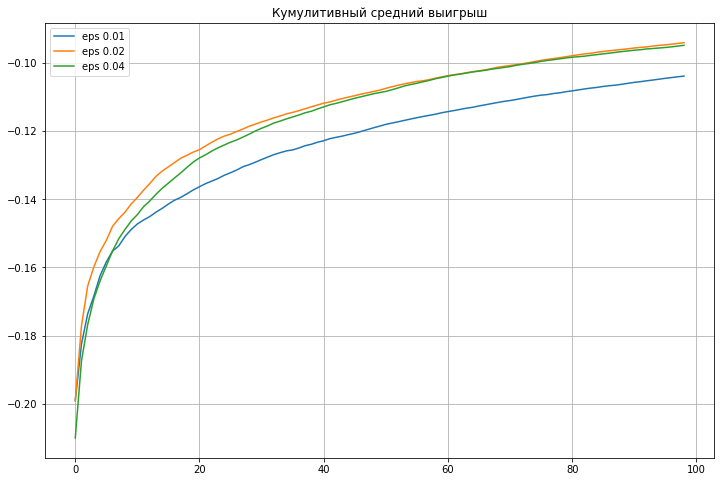

In [48]:
for eps in eps_list:
    plt.plot(reward_cum[eps], label='eps ' + str(eps))
plt.grid()
plt.legend()
plt.title('Кумулитивный средний выигрыш')
plt.show()

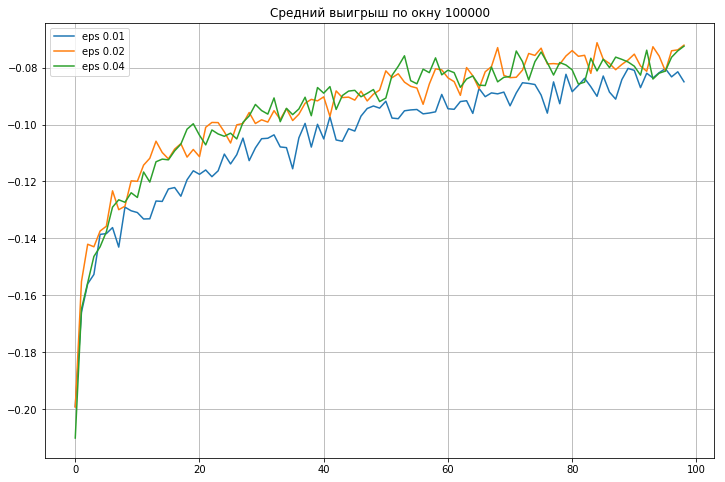

In [49]:
for eps in eps_list:
    plt.plot(reward_window[eps], label='eps ' + str(eps))
plt.grid()
plt.legend()
plt.title('Средний выигрыш по окну ' + str(window))
plt.show()

Подсчет карт не увеличил выигрыш, но графики все еще идут вверх. Из-за большего количества возможных состояний требуется силно больше времени на обучение

Пробовал уменьшать е со временем в 1 и 2 части, но улучшений не дало